# CS221 - Project

* Build Model
* Download Colorectal histography data
* Compile Model
* Setup Tensorboard callback
* Setup Checkpoints callback
* Train the model
* Evaluate accuracy
* Inference
* View weights and bias

## Things to do 
* Discriminator - include tensorboard callbacks, save model - retrieve model
* Generator
    * Setup the model
* Integrate generator + discriminator = GAN
    * Framework to train GAN
    * Include tensorboard callbacks in this
    * Save and retrieve model parameters in this


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import random
import pathlib
import tensorboard
import os
from datetime import datetime

SEED = 1965284
random.seed(SEED)
np.random.seed(SEED)
print(tf.__version__)

2.4.1


In [2]:
#tfds.list_builders()
#dset = tfds.load('colorectal_histology_large', split='train[:80%]', shuffle_files=True, \
#                 as_supervised=True, data_dir="/mnt/d/projct/data/")

# ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
class_list = ['07_ADIPOSE']

In [3]:
def load_dataset(dataset_directory_path, class_list):
    classes = os.listdir(dataset_directory_path)
    examples = []
    X, Y = [], []
    for label in classes:
        if (label in class_list):
            num_samples = len(os.listdir(os.path.join(dataset_directory_path,label)))
            print(label + '\t' + str(num_samples))
            random_image_index = random.choice(np.arange(num_samples)) 
            random_image_filename = os.listdir(os.path.join(dataset_directory_path,label))[random_image_index] 
            with Image.open(os.path.join(dataset_directory_path,label, random_image_filename)) as img:
                examples.append( np.array(img))

            y_label = int(label[:2])
            print("label, y_label : ", label, y_label)

            file_names = os.listdir(os.path.join(dataset_directory_path,label))
            for file_name in file_names:
                with Image.open(os.path.join(dataset_directory_path,label, random_image_filename)) as img:
                    img = (np.array(img)-127.5)/127.5
                    X.append( np.array(img) )
                    Y.append(y_label)
            print("len(X), len(Y) : ", len(X), len(Y))
    
    print(Y[:10])
    temp = list(zip(X,Y))
    random.shuffle(temp)
    X,Y = zip(*temp)
    print(Y[:10])
    X = np.array(X)
    Y = np.array(Y)
    return(X, Y, examples, classes)


DATASET_DIR = "./data/colorectal_histology/Kather_texture_2016_image_tiles_5000/"
X,Y,examples,classes = load_dataset(DATASET_DIR, class_list)

07_ADIPOSE	625
label, y_label :  07_ADIPOSE 7
len(X), len(Y) :  625 625
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
(7, 7, 7, 7, 7, 7, 7, 7, 7, 7)


-0.796078431372549 1.0 [0.78039216 0.63921569 0.76470588]
[7 7 7 7 7 7 7 7 7 7]


<ipython-input-4-c2dfd1a95fb2>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


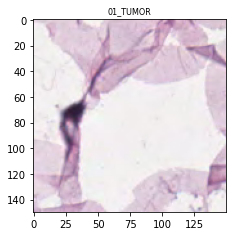

In [4]:
def show_examples(images, labels,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
        
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.title(labels[i], fontsize=label_font_size); 
        
print(np.amin(X[0]), np.amax(X[0]), X[0][0,0,:10])
print(Y[:10])

show_examples(examples, classes)

# Discriminator

* Create discriminator model
* Create fake dataset
* Mix fake and real dataset and train descriminator

In [5]:
def discriminator(dim=150, learningRate=0.002):
    model = tf.keras.Sequential()
    
    model.add( tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(dim,dim,3)) ) 
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 3
    # output shape: 150, 150, 64
    # parameters: weights=(3*3*3)*64 , biases=64

    model.add( tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 64
    # output shape: 150, 150, 128
    # parameters: weights=(3*3*64)*128 , biases=128

    model.add( tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 128
    # output shape: 150, 150, 128
    # parameters: weights=(3*3*128)*128 , biases=128
    
    model.add( tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 128
    # output shape: 150, 150, 256
    # parameters: weights=(3*3*128)*256 , biases=256

    model.add( tf.keras.layers.Flatten()) 
    model.add( tf.keras.layers.Dropout(0.4) ) 
    model.add( tf.keras.layers.Dense(1, activation="sigmoid") ) 
    
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate, beta_1=0.5),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [6]:
model_d = discriminator(learningRate=0.0002)
model_d.summary()
#tf.keras.utils.plot_model(model_d, "model_discriminator.png", show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 256)       2

In [7]:
def generate_fake_samples_naive(dim, batch_size):
    X = np.random.rand(dim * dim * 3 * batch_size)
    X = X.reshape((batch_size, dim, dim, 3))
    X = -1 + X * 2 # scale to [-1,1]
    Y = np.zeros(batch_size, dtype=int)
    return X, Y

In [8]:
if False:
    X_fake, Y_fake = generate_fake_samples_naive(dim=150, batch_size=5000)
    Y_real = np.ones(5000, dtype=int)
    print(X.shape)
    print(Y.shape)
    print(X_fake.shape)
    print(Y_fake.shape)
    print(Y[0],Y_fake[0], Y_real[0])
    X_d = np.concatenate((X, X_fake))
    Y_d = np.concatenate((Y_real, Y_fake))
    print(X_d.shape)
    print(Y_d.shape)

    temp = list(zip(X_d,Y_d))
    random.shuffle(temp)
    X_d,Y_d = zip(*temp)
    X_d = np.array(X_d)
    Y_d = np.array(Y_d)
    print(X_d.shape)
    print(Y_d.shape)

In [9]:
# Tensorboard callbacks - not yet integrated to discriminator

"""
print(tensorboard.__version__)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, 
                                                      write_images=True, 
                                                      histogram_freq=1,
                                                     )
# save checkpoints
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.save("/tmp/model")
"""

'\nprint(tensorboard.__version__)\nlogdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, \n                                                      write_images=True, \n                                                      histogram_freq=1,\n                                                     )\n# save checkpoints\ncheckpoint_path = "training_1/cp.ckpt"\ncheckpoint_dir = os.path.dirname(checkpoint_path)\n\n# Create a callback that saves the model\'s weights\ncp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,\n                                                 save_weights_only=True,\n                                                 verbose=1)\nmodel.save("/tmp/model")\n'

In [10]:
def fetch_real_samples(dataset, batch_size):
    """
    pass 5000 real examples to this function
    function randomly selects batch_size number of input samples and returns
    X, Y=1 
    """
    ix = np.random.randint(0, dataset.shape[0], batch_size)
    X = dataset[ix]
    Y = np.ones((batch_size, 1))
    return X, Y

In [11]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    
    for i in range(n_iter):
        X_real, y_real = fetch_real_samples(dataset, half_batch)
        #print("X_real.shape, y_real.shape : ", X_real.shape, y_real.shape)
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples_naive(dim=150, batch_size=half_batch)
        #print("X_fake.shape, y_fake.shape : ", X_fake.shape, y_fake.shape)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 

In [12]:
manual_training = True
if manual_training is False:
    model_d.fit(X_d, Y_d, epochs=3, batch_size=64, 
          shuffle=True, validation_split=0.1, verbose=1
         )
else:
    train_discriminator(model_d, dataset=X)


>1 real=25% fake=0%
>2 real=100% fake=98%
>3 real=100% fake=100%
>4 real=100% fake=100%
>5 real=100% fake=100%
>6 real=100% fake=100%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


In [13]:
# Generator 
    

In [14]:
def generator(latent_dim=100):
    model = tf.keras.Sequential()
    # foundation for 19x19 image
    n_nodes = 256 * 19 * 19
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((19, 19, 256)))
    # upsample to 38x38
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 76x76
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    ## upsample to 152x152
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    ## upsample to 150x150
    ##model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), output_padding=(-4,-4) ))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # output layer
    model.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

# (n+2p-f)/s + 1 = output
# n=76, s=2, f=4, output=150 -> p=113

In [15]:
latent_dim = 100
model_g = generator(latent_dim)
model_g.summary()
#tf.keras.utils.plot_model(model_g, "model_generator.png", show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 92416)             9334016   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 92416)             0         
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 38, 38, 128)       524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 76, 76, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 76, 76, 128)      

(9, 152, 152, 3) (9, 1)


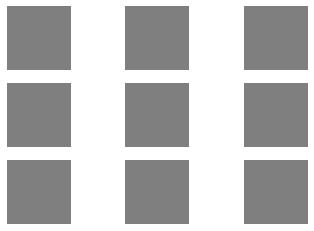

In [16]:
# create 9 fake examples

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, batch_size):
    x_input = np.random.randn(latent_dim * batch_size)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(model_g, latent_dim, batch_size):
    x_input = generate_latent_points(latent_dim, batch_size)
    X = model_g.predict(x_input)
    y = np.zeros((batch_size, 1))
    return X, y

X_g_out, Y_g_out = generate_fake_samples(model_g, latent_dim=100, batch_size=9)
print(X_g_out.shape, Y_g_out.shape)
X_g_out = (X_g_out + 1) / 2.0

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(X_g_out[i])
plt.show()

In [17]:
# GAN

def define_gan(model_g, model_d):
    # make weights in the discriminator not trainable
    model_d.trainable = False
    model = tf.keras.Sequential()
    model.add(model_g)
    model.add(model_d)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer= tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
                 )
    return model


In [18]:
model_gan = define_gan(model_g, model_d)

In [19]:
model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 152, 152, 3)       10386435  
_________________________________________________________________
sequential (Sequential)      (None, 1)                 610817    
Total params: 10,997,252
Trainable params: 10,386,435
Non-trainable params: 610,817
_________________________________________________________________


In [20]:
# create and save a plot of generated images
def save_plot(label, examples, epoch, n=3):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = 'results/'+label+'/generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(label, epoch, model_g, model_d, dataset, latent_dim, n_samples=150):
    X_real, y_real = fetch_real_samples(dataset, n_samples)
    _, acc_real = model_d.evaluate(X_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(model_g, latent_dim, n_samples)
    _, acc_fake = model_d.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(label, x_fake, epoch)
    filename = 'results/'+label+'/model_generator_%03d.h5' % (epoch+1)
    model_g.save(filename) 

In [21]:
# train the generator and discriminator
def train(model_g, model_d, model_gan, dataset, latent_dim, n_epochs=20, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)  #157
    half_batch = int(n_batch / 2)   #64
    print("train : ", n_epochs, bat_per_epo, half_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):  #157
            
            # get randomly selected 'real' samples
            X_real, y_real = fetch_real_samples(dataset, half_batch) #64
            # update discriminator model weights
            d_loss1, _ = model_d.train_on_batch(X_real, y_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(model_g, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = model_d.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = model_gan.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        kk = 1
        label = class_list[0]
        if (i+1) % kk == 0:
            summarize_performance(label, i, model_g, model_d, dataset, latent_dim)

In [22]:
train(model_g, model_d, model_gan, dataset=X, n_epochs=100, latent_dim=100)

train :  100 4 64
>1, 1/4, d1=0.000, d2=0.484 g=1.259
>1, 2/4, d1=0.000, d2=0.293 g=2.049
>1, 3/4, d1=0.000, d2=0.101 g=3.347
>1, 4/4, d1=0.000, d2=0.026 g=4.497
>Accuracy real: 100%, fake: 100%
>2, 1/4, d1=0.013, d2=0.012 g=5.069
>2, 2/4, d1=0.001, d2=0.010 g=5.267
>2, 3/4, d1=0.002, d2=0.013 g=5.705
>2, 4/4, d1=0.004, d2=0.026 g=7.478
>Accuracy real: 100%, fake: 100%
>3, 1/4, d1=0.022, d2=2.298 g=0.718
>3, 2/4, d1=0.000, d2=0.924 g=2.075
>3, 3/4, d1=0.067, d2=0.365 g=6.581
>3, 4/4, d1=5.179, d2=1.264 g=0.444
>Accuracy real: 100%, fake: 0%
>4, 1/4, d1=0.784, d2=0.932 g=1.184
>4, 2/4, d1=0.468, d2=0.764 g=0.755
>4, 3/4, d1=0.058, d2=0.657 g=1.121
>4, 4/4, d1=0.143, d2=0.437 g=1.406
>Accuracy real: 100%, fake: 100%
>5, 1/4, d1=0.276, d2=0.424 g=1.356
>5, 2/4, d1=0.084, d2=0.370 g=1.499
>5, 3/4, d1=0.090, d2=0.325 g=1.517
>5, 4/4, d1=0.067, d2=0.342 g=1.524
>Accuracy real: 100%, fake: 100%
>6, 1/4, d1=0.255, d2=0.373 g=1.461
>6, 2/4, d1=0.050, d2=0.377 g=1.370
>6, 3/4, d1=0.036, d2=0.402

>39, 3/4, d1=0.192, d2=0.206 g=4.673
>39, 4/4, d1=0.361, d2=0.398 g=4.020
>Accuracy real: 100%, fake: 100%
>40, 1/4, d1=0.101, d2=0.119 g=3.713
>40, 2/4, d1=0.152, d2=0.162 g=4.188
>40, 3/4, d1=0.168, d2=0.144 g=3.886
>40, 4/4, d1=0.141, d2=0.178 g=4.439
>Accuracy real: 100%, fake: 100%
>41, 1/4, d1=0.085, d2=0.232 g=4.926
>41, 2/4, d1=0.261, d2=0.203 g=4.229
>41, 3/4, d1=0.120, d2=0.079 g=4.123
>41, 4/4, d1=0.100, d2=0.120 g=4.238
>Accuracy real: 100%, fake: 100%
>42, 1/4, d1=0.059, d2=0.101 g=3.794
>42, 2/4, d1=0.088, d2=0.111 g=4.336
>42, 3/4, d1=0.140, d2=0.138 g=4.474
>42, 4/4, d1=0.156, d2=0.164 g=4.315
>Accuracy real: 100%, fake: 100%
>43, 1/4, d1=0.059, d2=0.092 g=4.199
>43, 2/4, d1=0.102, d2=0.170 g=5.475
>43, 3/4, d1=0.270, d2=0.244 g=3.891
>43, 4/4, d1=0.060, d2=0.065 g=5.055
>Accuracy real: 100%, fake: 100%
>44, 1/4, d1=0.058, d2=0.111 g=4.586
>44, 2/4, d1=0.082, d2=0.059 g=4.463
>44, 3/4, d1=0.063, d2=0.092 g=4.587
>44, 4/4, d1=0.105, d2=0.136 g=5.361
>Accuracy real: 100%,

>Accuracy real: 100%, fake: 100%
>85, 1/4, d1=0.001, d2=0.001 g=7.759
>85, 2/4, d1=0.001, d2=0.001 g=7.842
>85, 3/4, d1=0.001, d2=0.001 g=7.751
>85, 4/4, d1=0.001, d2=0.001 g=7.847
>Accuracy real: 100%, fake: 100%
>86, 1/4, d1=0.000, d2=0.001 g=7.780
>86, 2/4, d1=0.001, d2=0.001 g=7.729
>86, 3/4, d1=0.001, d2=0.001 g=7.671
>86, 4/4, d1=0.001, d2=0.001 g=7.848
>Accuracy real: 100%, fake: 100%
>87, 1/4, d1=0.001, d2=0.001 g=7.680
>87, 2/4, d1=0.001, d2=0.001 g=7.904
>87, 3/4, d1=0.001, d2=0.001 g=7.814
>87, 4/4, d1=0.001, d2=0.001 g=7.833
>Accuracy real: 100%, fake: 100%
>88, 1/4, d1=0.001, d2=0.001 g=7.763
>88, 2/4, d1=0.001, d2=0.001 g=7.735
>88, 3/4, d1=0.001, d2=0.001 g=7.734
>88, 4/4, d1=0.001, d2=0.001 g=7.860
>Accuracy real: 100%, fake: 100%
>89, 1/4, d1=0.000, d2=0.001 g=7.934
>89, 2/4, d1=0.001, d2=0.001 g=7.893
>89, 3/4, d1=0.001, d2=0.001 g=7.893
>89, 4/4, d1=0.001, d2=0.001 g=7.945
>Accuracy real: 100%, fake: 100%
>90, 1/4, d1=0.000, d2=0.001 g=7.878
>90, 2/4, d1=0.001, d2=0.

In [23]:
#summarize_performance(0, model_g, model_d, dataset=X, latent_dim=100)